In [139]:
import keras
import tensorflow as tf
try:
  import keras_tuner as kt
except:
  !pip install keras-tuner
  import keras_tuner as kt
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input, BatchNormalization, Normalization
from keras.models import Sequential
from keras.datasets import cifar10
from keras.utils import to_categorical
import sklearn
import io
import os
import datetime
# Helper to plot loss
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.legend()
  plt.grid(True)
  plt.show()

def plot_acc(history):
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label='val_accuracy')
  plt.legend()
  plt.grid(True)
  plt.show()

In [140]:
# Parameters and Settings
BASE_EPOCHS = 5
BATCH_SIZE = 1024
BASE_PATIENCE = 5
MIN_DELTA = .02
MONITOR = "val_loss"
CRITERIA = "min"
LOGS = "logs"
DIR_OUT = "kt_out"
PROJECT = "kt_basics"
FACTOR = 3
VALIDATION = .2
MAX_TRIALS = 3

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
  BASE_EPOCHS = 6
  BATCH_SIZE = 1024
  BASE_PATIENCE = 3
  MAX_TRIALS = 10
  !pip install keras_tuner

# Metrics
acc = keras.metrics.CategoricalAccuracy(name="accuracy")
pre = keras.metrics.Precision(name="precision")
rec = keras.metrics.Recall(name="recall")
metric_list = [acc, pre, rec]

HPARAM = True

stopping = keras.callbacks.EarlyStopping(
    monitor=MONITOR,
    min_delta=MIN_DELTA,
    patience=BASE_PATIENCE,
    mode=CRITERIA,
    restore_best_weights=True
)

# Keras Tuner

We can use the Keras Tuner to find the best hyperparameters for our model, in a similar way to how we usd a grid search to find the best hyperparameters for our scikit-learn models. The process is a little more involved, but it's still pretty straightforward. 

### Logs and Records

All of the stuff we are looking at here relies on log and record files being saved to disk. We can save them anywhere, but it is probably a good idea to consolidate them in some organized way. We can do this by creating a new directory called `logs` in the root of our project, and putting the log results in there. One thing to watch out for is that you can sometimes get odd errors or warnings if you are looking at the log files for some other model. This is because it is expecting to find things that it has written for the model to which it belongs. This is very annoying, ask me how I know. For real applications, youd probably want to make specific folders to track these things - for our repeated trials, I have added a little datetime stamp to some file names to just ensure that they are unique.

#### Load Data

We will start with using the cifar dataset. 

This is loaded up above. 

In [141]:
# Note: the class names are taken from the documentation
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
y_test = to_categorical(y_test)
y_train = to_categorical(y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 10) (10000, 32, 32, 3) (10000, 10)


In [142]:
import random

import matplotlib.pyplot as plt

def display_image_grid(dataset=X_train, indices=None):
    """
    Displays a grid of 4 images from the given dataset.

    Parameters:
    - dataset: The dataset to display images from. Defaults to X_train.
    - indices: A list of up to 4 integers specifying which images to include. 
               If None or fewer than 4 entries, selects randomly.
    """
    if indices is None or len(indices) < 4:
        indices = indices or []
        indices += random.sample(range(len(dataset)), 4 - len(indices))
    
    fig, axes = plt.subplots(2, 2, figsize=(4, 4))
    for i, ax in enumerate(axes.flat):
        ax.imshow(dataset[indices[i]])
        ax.axis('off')
        #ax.set_title(f'Label: {class_names[np.argmax(y_train[indices[i]])]} \nIndex: {indices[i]}')
        ax.set_title(str(indices[i])+": "+class_names[np.argmax(y_train[indices[i]])])
    plt.show()

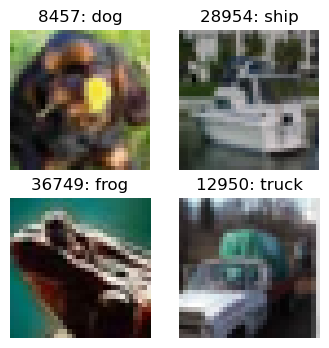

In [131]:
display_image_grid()

## Model Builder

To use Keras Tuner, you need to define a model builder function. This function takes a hyperparameter dictionary as input and returns a compiled model. In plain language, the model builder function is basically a framework for creating a model, with the key difference that we set things up so that the hyperparameters that we are testing are variables in the model construction. 

### HP.whatever

The hyperparameters that we are testing are defined using the HP.[Type_of_choice] functions. For example, HP.Choice defines a hyperparameter that can take on one of a list of values. HP.Float defines a hyperparameter that can take on any value between a minimum and maximum value. HP.Int defines a hyperparameter that can take on any integer value between a minimum and maximum value. Each thing that we want to change in the search is set up with one of these "hp." functions, along with the range of values we want to test.

When the hyperparameter search is called, these hyperparameters will be varied according to the search algorithm that we choose - just as a grid search would work through the various combinations of hyperparameters in the list we supply. We can build this model builder function to test almost anything we can think of - different number of neurons, different number of layers, different types of layers, different activation functions, different optimizers, different learning rates, etc... The possibilities of what we can test are really only limited by our imagination and the time it takes to run the search. Some key hp items to be aware of are:
<ul>
<li>HP.Choice - a hyperparameter that can take on one of a list of values</li>
<li>HP.Float - a hyperparameter that can take on any value between a minimum and maximum value</li>
<li>HP.Int - a hyperparameter that can take on any integer value between a minimum and maximum value</li>
</ul>

In [132]:
def model_builder(hp):
    model = Sequential()
    model.add(Input(shape=(32, 32, 3)))

    for i in range(hp.Int("conv_layers", 1, 3)):
        model.add(Conv2D(hp.Int(f"filters_{i}", 32, 256, step=32), 3, activation="relu"))
        model.add(MaxPooling2D())
    
    model.add(Flatten())
    for i in range(hp.Int("dense_layers", 1, 2)):
        model.add(Dense(hp.Int(f"dense_units_{i}", 32, 256, step=32), activation="relu"))
    
    model.add(Dense(10))
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [.01, .001, .0001])),
                    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                    metrics=["accuracy"])
    return model

## Hypertuning

Our model builder is the core of the hyperparameter tuning process, using it is relatively simple. We use the model builder as an input to the type of parameter search we want to do, there are a few options offered in the keras tuner:
<ul>
<li> Grid search - searches over a grid of hyperparameters like we are used to. </li>
<li> Random search - randomly selects hyperparameters from the search space and trains a model for each combination. </li>
<li> Hyperband - a more advanced search algorithm that uses early stopping to quickly identify high-performing models. This is a good option when you have a large search space and want to run a quick search. (The factor represents a ratio that the algorithm reduces the number of models trained from trial to trial, lower values leave more models)</li>
<li> Bayesian optimization - uses Bayesian optimization to identify high-performing hyperparameter values. Specifically, it starts by randomly selecting things, then uses performance to be smart about which others to select. </li>
</ul>

Once we've setup the search, we call the search() function in a very similar way to the fit() function. The search() function will run the search and find the best set of hyperparameters for our model. The Baeysian or Hyperband will likely perform much more quickly, especially as the seach space expands. 

In [133]:
tuner = kt.Hyperband(hypermodel = model_builder,
                     objective=MONITOR,
                     max_epochs=BASE_EPOCHS,
                     factor=3,
                     directory=DIR_OUT,
                     project_name=PROJECT,
                     overwrite=True)

### First - Simple Model for Tensorboard

We'll generate some results so our tensorboard isn't naked when we pull it up, it's kind of bashful. This model is mostly so we have an example of 'many epochs' to see in the training results. The hyperparameter search tends to have lots of low epoch trials and we set the epochs relatively low because it is a slow process to begin with, so this will give us a real curve to look at.

In [134]:
tensorboard_callback0 = keras.callbacks.TensorBoard(log_dir=LOGS+"/basic", write_graph=False, write_images=False)

modelMini = Sequential()
modelMini.add(Input(shape=(32, 32, 3)))
modelMini.add(Conv2D(32, 3, activation="relu"))
modelMini.add(MaxPooling2D())
modelMini.add(Flatten())
modelMini.add(Dense(128, activation="relu"))
modelMini.add(Dense(10))
modelMini.compile(optimizer="adam", loss=keras.losses.CategoricalCrossentropy(from_logits=True), metrics=["accuracy"])
modelMini.summary()

callbacksMini = [stopping]
if HPARAM:
  callbacksMini.append(tensorboard_callback0)

historyMini = modelMini.fit(X_train, y_train, epochs=30, 
                            validation_split=VALIDATION, 
                            callbacks=callbacksMini,
                            batch_size=BATCH_SIZE,
                            verbose=1)
plot_loss(historyMini)
plot_acc(historyMini)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 7200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │       921,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 923,914 (3.52 MB)

 Trainable params: 923,914 (3.52 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.2062 - loss: 2.3227 - val_accuracy: 0.3541 - val_loss: 1.8232
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.3798 - loss: 1.7546 - val_accuracy: 0.4271 - val_loss: 1.6444
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.4467 - loss: 1.5954 - val_accuracy: 0.4640 - val_loss: 1.5398
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.4775 - loss: 1.5008 - val_accuracy: 0.4764 - val_loss: 1.4808
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.5017 - loss: 1.4259 - val_accuracy: 0.5141 - val_loss: 1.4063
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.5168 - loss: 1.3730 - val_accuracy: 0.5200 - val_loss: 1.3841
Epoch 7/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.5417 - loss: 1.3151 - val_accuracy: 0.5272 - val_loss: 1.3540
Epoch 8/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.5579 - loss: 1.2786 - val_accuracy: 0.5378 - v

KeyboardInterrupt: 

In [125]:
%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6009 (pid 7746), started 7:54:58 ago. (Use '!kill 7746' to kill it.)

### Get Results

We can get the results of the trial, just like in a grid seach. One note on getting the best models or parameters down below is that we can get more than one. Below we are only grabbing the best model and hyperparameters, but we could get the top 3 or however many we wanted. 

In [126]:
# Get Results
tensorboard_callback1 = keras.callbacks.TensorBoard(log_dir=LOGS+"/hparam1", write_graph=False, write_images=True)
callbacks1 = [stopping]
if HPARAM:
  callbacks1.append(tensorboard_callback1)
tuner.search(X_train, y_train, epochs=BASE_EPOCHS, validation_split=VALIDATION, callbacks=callbacks1, batch_size=BATCH_SIZE)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of conv layers is {best_hps.get('conv_layers')}, 
the optimal number of dense layers is {best_hps.get('dense_layers')}, 
the optimal number of filters is {best_hps.get('filters_0')}, 
the optimal number of dense units is {best_hps.get('dense_units_0')}, 
and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')},
The performance of the best model is:
{best_model.evaluate(X_test, y_test)}
""")

Trial 3 Complete [00h 00m 23s]
val_loss: 2.0288808345794678

Best val_loss So Far: 2.0288808345794678
Total elapsed time: 00h 01m 10s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
1                 |1                 |conv_layers
128               |160               |filters_0
0.1               |0.1               |dropout_0
2                 |1                 |dense_layers
96                |224               |dense_units_0
0.0001            |0.01              |learning_rate
224               |32                |filters_1
0.1               |0                 |dropout_1
32                |192               |filters_2
0.4               |0.3               |dropout_2
224               |128               |dense_units_1
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
1                 |1                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
 5/40 ━━━━━━━━━━━━━

KeyboardInterrupt: 

## Train the Best Model

Once we have the best parameters, we can train a final model. Here I'll train a model on ALL of the data, since we already know the best parameter, this is the model that we think will do the best job and will be the one we can use in production.

In [72]:
# Build the model with the optimal hyperparameters and train it on the data
tensorboard_callback2 = keras.callbacks.TensorBoard(log_dir=LOGS+"/full_train1", write_graph=False, write_images=True)
model = tuner.hypermodel.build(best_hps)
callbacks2 = [stopping]
if HPARAM:
  callbacks2.append(tensorboard_callback2)
history = model.fit(X_train, y_train, epochs=BASE_EPOCHS, validation_split=VALIDATION, callbacks=callbacks2, batch_size=BATCH_SIZE)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 289ms/step - categorical_accuracy: 0.1983 - loss: 2.1702 - val_categorical_accuracy: 0.3659 - val_loss: 1.7513
Epoch 2/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 297ms/step - categorical_accuracy: 0.3658 - loss: 1.7498 - val_categorical_accuracy: 0.4361 - val_loss: 1.5674
Epoch 3/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 310ms/step - categorical_accuracy: 0.4391 - loss: 1.5586 - val_categorical_accuracy: 0.4723 - val_loss: 1.4748
Epoch 4/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 309ms/step - categorical_accuracy: 0.4763 - loss: 1.4757 - val_categorical_accuracy: 0.5031 - val_loss: 1.3955
Epoch 5/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 300ms/step - categorical_accuracy: 0.4976 - loss: 1.4137 - val_categorical_accuracy: 0.5131 - val_loss: 1.3439


KeyError: 'val_accuracy'

### Checkpoints 

We can also use checkpoints to save the best model as we go, this is a good way to make sure we don't lose our best model if we have to stop the training process early. This is also a good way to make sure we don't have to retrain the model if we have to restart the notebook.

#### Checkpoint Callback

We can build the checkpoint saving process into our model training fairly easily, by putting it into a callback. This callback is a lot like the early stopping one, but instead it just saves the weights of the model whenever it sees an improvement. If the next epoch is better, we save the updated model, if it is worse, we do nothing. On subsequent runs, we can load the weights from the checkpoint and continue training if we wish. 

In [144]:
file_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
filepath="logs/weights/weights-improvement-"+file_time+".keras"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor=MONITOR, verbose=1, save_best_only=True, mode=CRITERIA)

### Loading Weights

Only the weights are saved in the checkpoint, it is assumed we already have the model's structure. To pick up from our checkpoint, we need to:
<ul>
<li> Create a model that is the correct structure. </li>
<li> Retreive the weights from the checkpoint file. </li>
<li> Load the weights into the model. </li>
<li> Compile the model. </li>
</ul>

This will basically make a new model, that is exactly the same as the one that existed at the point in training when we saved the checkpoint.

#### Example of Checkpoint

We can see how this works by training a model a little, using the checkpoint callback, then loading the weights from the checkpoint and continuing training. I'll add a few layers and turn down the learning rate, so we can expect the training process to require a decent number of epochs. 

In [ ]:
modelCheck = keras.Sequential()
modelCheck.add(Input(shape=(32, 32, 3)))
modelCheck.add(Conv2D(64, (3, 3), activation='relu',  padding="same"))
modelCheck.add(MaxPooling2D((2, 2)))
modelCheck.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
modelCheck.add(MaxPooling2D((2, 2)))
modelCheck.add(Conv2D(256, (3, 3), activation='relu', padding="same"))
modelCheck.add(MaxPooling2D((2, 2)))

modelCheck.add(Flatten())
modelCheck.add(Dense(32, activation='relu'))
modelCheck.add(Dense(10))
modelCheck.summary()

In [ ]:
modelCheck.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(), metrics=metric_list)
train_logCheck = modelCheck.fit(X_train, y_train, epochs=10, batch_size=BATCH_SIZE, validation_split=.3, verbose=1, callbacks=[stopping, checkpoint])
test_evalCheck = modelCheck.evaluate(X_test, y_test, verbose=2)
plot_loss(train_logCheck)
plot_acc(train_logCheck)

### Recreating Checkpoint Model

We can now take the partially trained model that we just saved, recreate it into a new model, and continue training - or do any other model related activities that we had in mind. For this one I'll let the epochs be larger, so it can run a bit more. This training process will be a "new" one, but the starting point is where we left off with the checkpoint weights, in my trials I saw the first epoch ot have an accuracy of about 25%, the last epoch of the previous training to have an accuracy slightly under 50%, and our training here should pick up at somewhere around 50% and continue to improve.

In [ ]:
modelNew = keras.Sequential()
modelNew.add(Input(shape=(32, 32, 3)))
modelNew.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
modelNew.add(MaxPooling2D((2, 2)))
modelNew.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
modelNew.add(MaxPooling2D((2, 2)))
modelNew.add(Conv2D(256, (3, 3), activation='relu', padding="same"))
modelNew.add(MaxPooling2D((2, 2)))

modelNew.add(Flatten())
modelNew.add(Dense(32, activation='relu'))
modelNew.add(Dense(10))

# Load Weights
#/Volumes/Storage/git_courses/semester/1222/3950/Intro_to_Machine_Learning_Student_Workbooks/logs/weightsimport os
import glob

# There is a "get_latest_checkpoint" function in the keras documentation, but it doesn't work for me
# locally. That is probably a better solution, but it appears to have some bug
# There were a couple of post online about differences on mac/win/linux, but that's not certain. 
list_of_files = glob.glob("logs/weights/*.keras") 
latest = max(list_of_files, key=os.path.getctime)
print(latest)
modelNew.load_weights(latest)
modelNew.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=.0001), metrics=metric_list)

AttributeError: 'ModelCheckpoint' object has no attribute '_get_most_recently_modified_file'

In [ ]:
train_logNew = modelNew.fit(X_train, y_train, epochs=15, batch_size=BATCH_SIZE, validation_split=.3, verbose=1, callbacks=[stopping, 
                                                                                                                           checkpoint,
                                                                                                                           ])
train_evalNew = modelNew.evaluate(X_train, y_train)
test_evalNew = modelNew.evaluate(X_test, y_test, verbose=2)
plot_loss(train_logNew)
plot_acc(train_logNew)

### Recreating Checkpoint Model

We can now take the partially trained model that we just saved, recreate it into a new model, and continue training - or do any other model related activities that we had in mind. For this one I'll let the epochs be larger, so it can run a bit more. This training process will be a "new" one, but the starting point is where we left off with the checkpoint weights, in my trials I saw the first epoch ot have an accuracy of about 25%, the last epoch of the previous training to have an accuracy slightly under 50%, and our training here should pick up at somewhere around 50% and continue to improve.

### Adding Augmentation

We can also add data augmentation to our model, this is a good way to increase the size of our dataset and improve the generalization of our model. We can do this by adding a layer to our model that will randomly rotate, flip, zoom, and shift the images in our dataset. This will make our model more robust to changes in the input data and help it to generalize better to new data.

In [ ]:
agumentation_layers = Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(.2),
    keras.layers.RandomZoom(.2),
    keras.layers.RandomFlip("vertical"),
])
model_aug = Sequential()

model_aug.add(Input(shape=(32, 32, 3)))
model_aug.add(agumentation_layers)
model_aug.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model_aug.add(MaxPooling2D((2, 2)))
model_aug.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model_aug.add(MaxPooling2D((2, 2)))
model_aug.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model_aug.add(MaxPooling2D((2, 2)))
model_aug.add(Flatten())
model_aug.add(Dense(128, activation='relu'))
model_aug.add(Dense(10))

model_aug.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=True), 
                    optimizer=keras.optimizers.Adam(), 
                    metrics=["accuracy"])

train_log_aug = model_aug.fit(X_train, y_train, epochs=15, batch_size=BATCH_SIZE, validation_split=.3, verbose=1, callbacks=[stopping, checkpoint])

plot_loss(train_log_aug)
plot_acc(train_log_aug)

Epoch 1/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.1689 - loss: 2.2225
Epoch 1: val_loss improved from inf to 2.06956, saving model to logs/weights/weights-improvement-20250327-130853.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 202ms/step - accuracy: 0.1700 - loss: 2.2206 - val_accuracy: 0.2241 - val_loss: 2.0696
Epoch 2/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.2891 - loss: 1.9832
Epoch 2: val_loss did not improve from 2.06956
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.2895 - loss: 1.9821 - val_accuracy: 0.2439 - val_loss: 2.0913
Epoch 3/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.3325 - loss: 1.8614
Epoch 3: val_loss improved from 2.06956 to 1.98698, saving model to logs/weights/weights-improvement-20250327-130853.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.3328 - loss: 1.8607 - val_accuracy: 0.3119 - val_loss: 1.9870
Epoch 4/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.3549 - loss: 1.8052
Epoch 4: val_loss 

## Exercise

Implement a CNN model to classify the dataset. 

Try to:
<ul>
<li> Use a CNN model. </li>
<li> Use a checkpoint to save the best model. </li>
<li> Use tensorboard to monitor the training process. </li>
<li> Use some hyperparameter tuning to find the best model. </li>
</ul>

Note - there's 

In [137]:
import pathlib
import PIL 

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)
data_dir_tmp = pathlib.Path(pathlib.Path.joinpath(data_dir, "flower_photos"))
data_dir = data_dir_tmp

#Flowers
batch_size = BATCH_SIZE
img_height = 180
img_width = 180

train_ds = keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [ ]:
# Model
modelFlow = Sequential()
modelFlow.add(Input(shape=(img_height, img_width, 3)))
modelFlow.add(Conv2D(32, 3, activation="relu", padding="same", kernel_regularizer="l2"))
modelFlow.add(MaxPooling2D())
modelFlow.add(Conv2D(64, 3, activation="relu", padding="same", kernel_regularizer="l2"))
modelFlow.add(MaxPooling2D())
modelFlow.add(Conv2D(128, 3, activation="relu", padding="same", kernel_regularizer="l2"))
modelFlow.add(MaxPooling2D())
modelFlow.add(Flatten())
modelFlow.add(Dense(128, activation="relu"))
modelFlow.add(Dense(5))
modelFlow.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])
modelFlow.summary()


In [ ]:
tensorboard_callback_flower = keras.callbacks.TensorBoard(log_dir=LOGS+"/flower", write_graph=False, write_images=True)
callbacksFlower = [stopping]
if not HPARAM:
  callbacksFlower.append(tensorboard_callback_flower)

historyFlower = modelFlow.fit(train_ds, epochs=BASE_EPOCHS, validation_data=val_ds, callbacks=callbacksFlower)
plot_loss(historyFlower)
plot_acc(historyFlower)

### Custom Callbacks

We can also create custom callbacks, which can be used to do things like:
<ul>
<li> Save the model at certain intervals. </li>
<li> Save the model if it is the best one. </li>
<li> Change the learning rate. </li>
<li> Log the training process. </li>
<li> etc... </li>
</ul>

Callbacks are created by defining a new class that inherits from the keras.callbacks.Callback class, then overriding the methods that we want to use. Actions are triggered at certain points in the training process, the beginnings and ends of things like training, epochs, and batches. We can do almost anything in here, common tasks are saving training progress, logging custom data, and managing the learning rate. If there are any inputs like log file paths, test data, etc... they can be passed in as arguments to the constructor and stored as variables in the callback object.

#### Confusion Matrix Logger

This is a custom callback that will log the confusion matrix at the end of each epoch. In this one we display an image - to show images we need to first convert the confusion matrix to an image, then convert it to a tensor, then log it. That's something that I'd recommend looking up as needed, it is shown in the example. 

In [ ]:
class ConfusionMatrixCallback(keras.callbacks.Callback):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.X)
        y_pred = np.argmax(y_pred, axis=1)
        y_true = np.argmax(self.y, axis=1)
        cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
        #print(cm)
        figure = plt.figure(figsize=(8, 8))
        ax = figure.add_subplot(111)
        ax.matshow(cm, cmap='coolwarm', alpha=0.8)
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')

        # Convert the plot to an image tensor
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        plt.close(figure)
        buf.seek(0)
        image = tf.image.decode_png(buf.getvalue(), channels=4)
        image = tf.expand_dims(image, 0)

        # Log the image to TensorBoard
        with tf.summary.create_file_writer(LOGS).as_default():
            tf.summary.image("Confusion Matrix", image, step=epoch)

In [ ]:
# New small model - we can see improvements
modelSmall = keras.Sequential()
modelSmall.add(Input(shape=(32, 32, 3)))
modelSmall.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
modelSmall.add(MaxPooling2D((2, 2)))
modelSmall.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
modelSmall.add(MaxPooling2D((2, 2)))
modelSmall.add(Flatten())
modelSmall.add(Dense(128, activation='relu'))
modelSmall.add(Dense(10))

modelSmall.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                     optimizer=keras.optimizers.Adam(learning_rate=.00001),
                     metrics=metric_list)

In [ ]:
tensorboard_callback3 = keras.callbacks.TensorBoard(log_dir=LOGS+"/small_model", 
                                                    write_graph=False, 
                                                    write_images=True)
confusion_callback = ConfusionMatrixCallback(X_test, y_test)
callbacks3 = [stopping, confusion_callback]
if HPARAM:
  callbacks3.append(tensorboard_callback3)
historySmall = modelSmall.fit(X_train, y_train, 
                              epochs=50, 
                              validation_split=.3, 
                              callbacks=callbacks3, 
                              batch_size=BATCH_SIZE)

plot_loss(historySmall)
plot_acc(historySmall)

## Exercise

Use the flower data from the previous exercise and build another model. Use this callback, then try to make or modify your own and use it in the tensorboard. 